In [ ]:
import pandas as pd
import numpy as np


def forward(V, a, b, initial_distribution):
    alpha = np.zeros((V.shape[0], a.shape[0]))
    alpha[0, :] = initial_distribution * b[:, V[0]]

    for t in range(1, V.shape[0]):
        for j in range(a.shape[0]):
            # Matrix Computation Steps
            #                  ((1x2) . (1x2))      *     (1)
            #                        (1)            *     (1)
            alpha[t, j] = alpha[t - 1].dot(a[:, j]) * b[j, V[t]]

    return alpha


def backward(V, a, b):
    beta = np.zeros((V.shape[0], a.shape[0]))

    # setting beta(T) = 1
    beta[V.shape[0] - 1] = np.ones((a.shape[0]))

    # Loop in backward way from T-1 to
    # Due to python indexing the actual loop will be T-2 to 0
    for t in range(V.shape[0] - 2, -1, -1):
        for j in range(a.shape[0]):
            beta[t, j] = (beta[t + 1] * b[:, V[t + 1]]).dot(a[j, :])

    return beta


def baum_welch(V, a, b, initial_distribution, n_iter=100):
    M = a.shape[0]
    T = len(V)
    alpha1 = forward(V, a, b, initial_distribution)
    print("alpha matrix:", alpha1)
    for n in range(n_iter):
        alpha = forward(V, a, b, initial_distribution)
        beta = backward(V, a, b)

        xi = np.zeros((M, M, T - 1))
        for t in range(T - 1):
            denominator = np.dot(np.dot(alpha[t, :].T, a) * b[:, V[t + 1]].T, beta[t + 1, :])
            for i in range(M):
                numerator = alpha[t, i] * a[i, :] * b[:, V[t + 1]].T * beta[t + 1, :].T
                xi[i, :, t] = numerator / denominator

        gamma = np.sum(xi, axis=1)
        a = np.sum(xi, 2) / np.sum(gamma, axis=1).reshape((-1, 1))

        # Add additional T'th element in gamma
        gamma = np.hstack((gamma, np.sum(xi[:, :, T - 2], axis=0).reshape((-1, 1))))

        K = b.shape[1]
        denominator = np.sum(gamma, axis=1)
        for l in range(K):
            b[:, l] = np.sum(gamma[:, V == l], axis=1)

        b = np.divide(b, denominator.reshape((-1, 1)))

    return {"a":a, "b":b}


#data = pd.read_csv('data_python.csv')

#V = data['Visible'].values
#V=np.array([2,0,2])
V=np.array([1,0,2])

# Transition Probabilities
"""
a = np.ones((2, 2))
a = a / np.sum(a, axis=1)"""
a=np.array([[0.6,0.4],[0.5,0.5]])

# Emission Probabilities
"""
b = np.array(((1, 3, 5), (2, 4, 6)))
b = b / np.sum(b, axis=1).reshape((-1, 1))"""
#b=np.array([[0.2,0.4,0.4],[0.5,0.4,0.1]])
b=np.array([[0.07581633, 0.30326533, 0.01263606],
       [0.0398073 , 0.23884377, 0.00442303]])
b = b / np.sum(b, axis=1).reshape((-1, 1))

# Equal Probabilities for the initial distribution
initial_distribution = np.array((0.8, 0.2))

print(baum_welch(V, a, b, initial_distribution, n_iter=100))
forward(V, a, b, initial_distribution)
print(forward(V, a, b, initial_distribution))

alpha matrix: [[0.61935484 0.16875   ]
 [0.08825572 0.04670395]
 [0.00246147 0.00091647]]
{'a': array([[0., 1.],
       [0., 1.]]), 'b': array([[0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [5.0000000e-01, 1.3051717e-87, 5.0000000e-01]])}
[[0.63369369 0.04157658]
 [0.26826409 0.09078738]
 [0.1503665  0.04142903]]


In [ ]:
import scipy as sp
import numpy as np
from scipy import stats
from scipy.special import logsumexp
from numpy import seterr

class PHMMs:
	def __init__(self,init_ditri,init_trans_matrix,set_paramPoisson,ob_seqs,epsi):
		seterr(divide='ignore')
		self.nber_states=len(init_ditri)
		self.log_init_ditri=np.log(init_ditri)
		self.log_init_trans_matrix=np.log(init_trans_matrix)
		self.set_paramPoisson=np.array(set_paramPoisson)
		self.epsi=epsi
		self.ob_seqs=ob_seqs
		seterr(divide='warn')

	def log_prob_Poisson(self, mean, val):
		return stats.poisson(mean).logpmf(val)


	def matrix_alpha(self):#output la matrix alpha voi hang la tu 0 den N-1, cot la tu 0 den T-1
		seterr(divide='ignore')
		log_bi_o1=[self.log_prob_Poisson(self.set_paramPoisson[i],self.ob_seqs[0]) for i in range(self.nber_states) ]
		log_pibi_o1=np.add(self.log_init_ditri,log_bi_o1)
		alpha_matrix=[log_pibi_o1]
		for i in range(1,len(self.ob_seqs)):
			log_alpha_i=[]
			for j in range(self.nber_states):
				log_alpha_prev=alpha_matrix[-1]
				log_prev_mulA=np.add(log_alpha_prev,self.log_init_trans_matrix[::,j])
				sumlog=logsumexp(log_prev_mulA)
				alpha_ij=sumlog+self.log_prob_Poisson(self.set_paramPoisson[j],self.ob_seqs[i])
				log_alpha_i.append(alpha_ij)
			alpha_matrix.append(log_alpha_i)
		alpha_T=alpha_matrix[-1]
		seterr(divide='warn')
		return np.array(alpha_matrix)

	def matrix_beta(self):#output laf ma tran beta voi beta[i] la tai t=i, 1 hang tu 1 den N(nberstates)
		seterr(divide='ignore')
		#log_b_oT=[self.log_prob_Poisson(self.set_paramPoisson[i],self.ob_seqs[-1]) for i in range(self.nber_states) ]
		log_b_oT=[0 for i in range(self.nber_states)]
		beta_matrix=[log_b_oT]
		for i in range(len(self.ob_seqs)-2,-1,-1):#i o day la t
			log_beta_i=[]
			for j in range(self.nber_states):#j ow day la i trong cong thuc
				log_beta_prev=beta_matrix[-1]
				log_prev_mulA=np.add(self.log_init_trans_matrix[j],log_beta_prev)
				emit_prob=[self.log_prob_Poisson(self.set_paramPoisson[k],self.ob_seqs[i+1]) for k in range(self.nber_states)]
				log_prev_mulA1=np.add(log_prev_mulA,emit_prob)
				sumlog=logsumexp(log_prev_mulA1)
				beta_ij=sumlog
				log_beta_i.append(beta_ij)
			beta_matrix.append(log_beta_i)
		beta_matrix.reverse()
		seterr(divide='warn')
		return np.array(beta_matrix)
	def check(self):#P(O|lambda)=prob_O
		temp1=self.matrix_alpha()
		temp2=self.matrix_beta()
		prob_O_directly=np.exp(logsumexp(temp1[-1]))
		return prob_O_directly
		
	def vterbi(self):
		v_n=[0.0 for _ in range(self.nber_states)]
		vlst=[v_n]
		wlst=[]
		for i in range(len(self.ob_seqs)-1,0,-1):
			v_i = []
			w_i = []
			for j in range(self.nber_states):
				all_v_ij = []
				for k in range(self.nber_states):
					temp = self.log_init_trans_matrix[j,k] + self.log_prob_Poisson(self.set_paramPoisson[k], self.ob_seqs[i])
					temp += vlst[-1][k]
					all_v_ij.append(temp)
				v_i.append(max(all_v_ij))
				w_i.append(np.argmax(all_v_ij))
			vlst.append(v_i)
			wlst.append(w_i)
		wlst.reverse()
		first_prob = [self.log_prob_Poisson(self.set_paramPoisson[i], self.ob_seqs[0]) for i in range(self.nber_states)]
		first_prob = np.add(first_prob, self.log_init_ditri)
		first_prob=np.add(first_prob, vlst[-1])
		h_1 = np.argmax(first_prob)
		statelst = [h_1]
		for i in range(len(wlst)):
			statelst.append(wlst[i][statelst[-1]])
		return statelst
	
	
	def numerator_update_trans(self,i,j):
		temp1=self.matrix_alpha()
		temp2=self.matrix_beta()
		C=0
		for t in range(len(self.ob_seqs)-1):
			A=temp1[t][i]+self.log_init_trans_matrix[i,j]+self.log_prob_Poisson(self.set_paramPoisson[j],self.ob_seqs[t+1])+temp2[t+1][j]
			B=np.exp(A)
			C=C+B
		return np.log(C)
	def denominator_update(self,i):
		temp1=self.matrix_alpha()
		temp2=self.matrix_beta()
		C=0
		for t in range(len(self.ob_seqs)-1):
			A=temp1[t][i]+temp2[t][i]
			B=np.exp(A)
			C=C+B
		return np.log(C)

	def numerator_update_lambda(self,i):
		temp1=self.matrix_alpha()
		temp2=self.matrix_beta()
		C=0
		for t in range(len(self.ob_seqs)-1):
			A=temp1[t][i]+temp2[t][i]
			B=np.exp(A)*self.ob_seqs[t]
			C=C+B
		return C

	def update_init_ditri(self):
		temp1=self.matrix_alpha()
		temp2=self.matrix_beta()
		L_T=self.check()
		for i in range(self.nber_states):
			self.log_init_ditri[i]=temp1[0][i]+temp2[0][i]-np.log(L_T)
		return True

		



	def Baum_Welch(self,max_iter=150):
		for itere in range(max_iter):
			pre_L_T=self.check()
			#update trans_matrix
			for i in range(self.nber_states):
				for j in range(self.nber_states):
					self.log_init_trans_matrix[i,j]=self.numerator_update_trans(i,j)-self.denominator_update(i)
			#update paramPoisson
			for i in range(self.nber_states):
				self.set_paramPoisson[i]=self.numerator_update_lambda(i)/(np.exp(self.denominator_update(i)))
			#update init_ditri
			self.update_init_ditri()
			current_L_T=self.check()		
			if (current_L_T) < np.exp(self.epsi)*pre_L_T and current_L_T > pre_L_T:break
		return True		

theta = np.array([[0.6, 0.4],[0.5, 0.5]]) 
delta = np.array([0.8, 0.2])
lambdas = np.array([0.5, 1/3])
epsi1=0.0001
#seqs=np.array([1, 1, 6, 5, 6, 10, 0, 9, 1, 0, 0, 8, 1, 1, 7, 5, 1, 1, 1, 0, 2, 3, 5, 5, 0, 2, 1, 0, 5, 3, 4, 5, 1, 6, 0, 7, 2, 0, 5, 6, 3, 9, 2, 3, 0, 1, 0, 1, 0, 4, 2, 4, 2, 9, 3, 0, 0, 4, 1, 1, 2, 8, 5, 1, 0, 9, 2, 0, 2, 3, 0, 7, 6, 7, 1, 0, 4, 1, 0, 2, 1, 6, 4, 6, 1, 7, 7, 6, 2, 6, 0, 1, 8, 6, 0, 1, 9, 9, 4, 1, 1, 8, 3, 1, 6, 3, 7, 0, 6, 1, 1, 1, 8, 2, 7, 1, 1, 2, 3, 5, 0, 0, 3, 2, 0, 5, 0, 2, 1, 1, 1, 2, 2, 0, 1, 2, 1, 4, 2, 1, 0, 1, 0, 0, 0, 4, 2, 3, 2, 5, 7, 1, 3, 3, 0, 1, 1, 8, 1, 0, 1, 1, 1, 7, 4, 2, 5, 4, 0, 2, 6, 2, 3, 1, 3, 0, 4, 2, 1, 0, 3, 4, 3, 4, 2, 3, 5, 1, 6, 2, 3, 3, 5, 0, 0, 5, 1, 6, 5, 1, 0, 6, 0, 3, 2, 2, 1, 1, 7, 0, 8, 1, 1, 1, 3, 2, 4, 2, 1, 4, 5, 1, 1, 3, 7, 1, 1, 1, 1, 4, 7, 0, 2, 5, 0, 4, 8, 8, 3, 1, 6, 6, 6, 1, 1, 3, 1, 3, 1, 7, 5, 9, 1, 2, 7, 1, 7, 10, 0, 2, 0, 0, 0, 7, 1, 1, 2, 4, 2, 2, 0, 7, 4, 2, 7, 0, 0, 0, 2, 4, 7, 0, 4, 0, 1, 1, 1, 1, 2, 6, 0, 2, 7, 1, 1, 7, 6, 1, 6, 4, 0, 1, 0, 6, 6, 0, 5, 1, 3, 1, 9, 5, 3, 1, 8, 1, 0, 6, 1, 7, 6, 2, 3, 7, 2, 4, 1, 2, 2, 5, 5, 1, 4, 2, 4, 0, 5, 3, 1, 1, 3, 1, 1, 7, 0, 4, 4, 6, 5, 0, 9, 1, 0, 5, 4, 2, 0, 1, 7, 3, 3, 1, 6, 2, 0, 1, 0, 3, 4, 0, 6, 3, 2, 0, 4, 1, 0, 0, 10, 4, 1, 0, 6, 1, 2, 0, 5, 10, 2, 1, 6, 5, 1, 2, 0, 3, 3, 7, 1, 1, 1, 1, 5, 5, 3, 3, 1, 1, 2, 0, 1, 5, 0, 0, 1, 6, 1, 7, 5, 3, 1, 3, 1, 3, 0, 0, 3, 6, 2, 3, 5, 5, 0, 1, 4, 0, 2, 3, 0, 7, 0, 5, 4, 5, 1, 6, 10, 3, 5, 0, 1, 3, 5, 1, 1, 10, 4, 1, 1, 1, 2, 6, 1, 0, 6, 2, 0, 5, 6, 6, 5, 1, 0, 7, 3, 11, 6, 1, 2, 2, 2, 3, 2, 0, 1, 0, 0, 1, 2, 7, 4, 1, 7, 9, 5, 4, 4, 4, 1, 2, 1, 1, 1, 3, 1, 1, 7, 0, 7, 1, 0, 4, 12, 6, 5, 4, 2, 12, 1, 4, 6, 2, 4, 8, 4, 0, 8, 3, 4, 6, 2, 1, 0, 0, 1, 1, 1, 13, 4, 8, 4, 2, 6, 3, 1, 2, 4, 7, 5, 1, 2, 2, 3, 4, 5, 7, 3, 3, 3, 7, 1, 0, 0, 5, 1, 4, 8, 5, 2, 2, 1, 5, 3, 5, 5, 0, 0, 1, 2, 2, 3, 9, 3, 1, 1, 8, 0, 1, 0, 1, 7, 1, 1, 0, 4, 1, 2, 5, 9, 3, 1, 0, 2, 1, 2, 9, 1, 5, 5, 6, 1, 2, 9, 2, 2, 2, 6, 0, 0, 0, 1, 1, 4, 1, 3, 1, 3, 7, 2, 1, 7, 1, 0, 3, 1, 3, 3, 1, 7, 1, 4, 7, 4, 5, 0, 3, 0, 5, 5, 6, 0, 0, 2, 0, 5, 9, 0, 0, 0, 6, 9, 1, 3, 2, 3, 5, 7, 5, 0, 7, 3, 13, 0, 1, 7, 0, 0, 3, 1, 1, 6, 2, 3, 2, 0, 1, 3, 3, 9, 4, 8, 1, 1, 0, 3, 4, 3, 0, 0, 0, 0, 1, 11, 4, 1, 5, 0, 1, 2, 6, 1, 1, 0, 1, 0, 1, 9, 3, 3, 9, 1, 5, 4, 9, 8, 0, 2, 5, 6, 1, 4, 2, 1, 1, 2, 10, 1, 3, 1, 3, 3, 0, 1, 1, 1, 6, 2, 4, 0, 7, 3, 4, 2, 5, 1, 2, 0, 3, 6, 1, 5, 2, 0, 1, 0, 4, 1, 0, 0, 0, 0, 1, 4, 7, 1, 1, 2, 0, 1, 6, 1, 1, 10, 5, 6, 4, 3, 0, 0, 4, 8, 1, 6, 4, 10, 2, 6, 1, 5, 2, 1, 2, 7, 5, 3, 2, 0, 0, 5, 7, 3, 1, 0, 1, 4, 6, 6, 5, 0, 1, 1, 1, 2, 3, 3, 0, 1, 12, 6, 1, 0, 5, 2, 1, 1, 0, 1, 5, 0, 1, 4, 2, 2, 3, 1, 0, 0, 4, 5, 3, 4, 5, 10, 4, 0, 2, 0, 1, 4, 7, 1, 1, 1, 2, 2, 0, 3, 1, 6, 4, 1, 3, 6, 1, 0, 2, 3, 7, 2, 6, 6, 4, 3, 1, 2, 6, 6, 1, 4, 0, 2, 0, 0, 2, 1, 5, 4, 5, 5, 0, 2, 4, 2, 11, 3, 0, 3, 2, 3, 1, 7, 7, 6, 4, 5, 2, 10, 1, 4, 3, 0, 2, 7, 5, 4, 0, 0, 6, 3, 1, 7, 12, 0, 5, 9, 3, 0, 0, 2, 6, 0, 2, 5, 4, 1, 9, 0, 5, 5, 8, 1, 7, 3, 3, 3, 1, 2, 1, 0, 1, 5, 3, 1, 3, 2, 1, 0, 3, 1, 6, 1, 10, 6, 7, 5, 7, 0, 7, 0, 1, 7, 0, 1, 2, 1, 1, 2, 1, 2, 2, 2, 3, 4, 5, 2, 3, 5, 7, 10, 3, 1, 7, 2, 2, 12, 4, 3, 3, 2, 1, 2, 2, 2, 13, 1, 4, 5, 0, 5, 1, 6, 0, 16, 2, 0, 3, 1, 6, 1, 0, 5, 4, 1, 2, 2, 2, 0, 5, 2, 9, 1, 2, 4, 3, 6, 8, 6, 6, 6, 2, 0, 6, 3, 9, 6, 0, 7, 0, 7, 1, 3, 1, 1, 2, 0, 6, 1, 7, 6, 1, 7, 0, 4, 1, 1, 0, 1, 4, 2, 0, 0, 4, 3, 4, 3, 7, 6, 0, 1, 9, 1, 0, 1, 1, 8, 4, 10, 0, 8, 6, 2, 2, 2, 7, 1, 4, 1, 8, 1, 8, 5, 6, 0, 2, 6, 1, 4, 1, 3, 4, 10, 8, 1, 7, 5, 0, 6, 0, 5, 1, 1, 5, 4, 1, 5, 0, 1, 4, 2, 1, 4, 8, 2, 12, 1, 3, 0, 0, 0, 0, 1, 2, 8, 4, 1, 3, 1, 4, 0, 0, 1, 0, 1, 2, 5, 2, 1, 2, 1, 1, 1, 3, 5, 2, 0, 7, 6, 3, 4, 6, 1, 5, 7, 1, 2, 3, 1, 0, 0, 6, 4, 2, 9, 1, 1, 1, 2, 5, 3, 4, 2, 4, 5, 1, 1, 1, 6, 0, 3, 2, 6, 2, 5, 4, 3, 1, 1, 5, 6, 8, 0, 1, 8, 0, 9, 0, 0, 3, 0, 2, 1, 1, 4, 1, 6, 4, 1, 4, 6, 1, 1, 0, 9, 0, 0, 2, 1, 5, 7, 5, 5, 7, 1, 5, 1, 4, 1, 1, 1, 1, 1, 1, 9, 2, 0, 1, 3, 6, 2, 3, 3, 0, 2, 1, 0, 9, 3, 11, 2, 2, 6, 1, 1, 1, 3, 1, 5, 0, 2, 1, 2, 1, 6, 7, 2, 0, 9, 0, 1, 2, 1, 3, 1, 2, 6, 0, 6, 0, 0, 5, 6, 0, 6, 1, 4, 10, 3, 0, 1, 0, 2, 5, 0, 0, 4, 5, 0, 8, 1, 0, 3, 1, 0, 1, 7, 8, 7, 0, 10, 0, 7, 5, 5, 6, 7, 3, 1, 10, 0, 5, 5, 8, 5, 1, 6, 1, 5, 1, 1, 5, 5, 3, 6, 0, 0, 0, 5, 6, 8, 1, 2, 0, 0, 0, 7, 7, 2, 0, 2, 0, 4, 8, 4, 8, 7, 2, 6, 0, 9, 5, 0, 4, 2, 1, 5, 1, 0, 3, 2, 1, 2, 0, 4, 0, 0, 8, 1, 2, 6, 2, 7, 0, 0, 0, 0, 7, 1, 0, 8, 0, 3, 0, 0, 0, 0, 1, 7, 7, 6, 0, 0, 6, 0, 5, 2, 6, 11, 1, 2, 6, 8, 5, 8, 2, 1, 5, 4, 3, 2, 0, 6, 0, 5, 0, 1, 0, 9, 5, 4, 1, 4, 5, 4, 3, 2, 1, 6, 1, 1, 1, 2, 8, 0, 3, 0, 7, 0, 3, 1, 2, 1, 2, 2, 1, 2, 0, 5, 8, 3, 3, 8, 6, 4, 1, 2, 6, 5, 5, 4, 7, 2, 6, 9, 4, 6, 4, 1, 0, 6, 1, 3, 2, 8, 1, 0, 0, 9, 4, 2, 2, 0, 4, 1, 6, 7, 1, 10, 0, 0, 4, 2, 0, 10, 1, 4, 0, 4, 5, 4, 0, 2, 2, 4, 1, 8, 4, 1, 7, 1, 7, 0, 0, 5, 6, 2, 4, 5, 6, 3, 9, 0, 0, 3, 9, 8, 1, 11, 9, 2, 1, 9, 5, 4, 2, 1, 1, 7, 10, 6, 0, 0, 4, 1, 9, 0, 4, 2, 0, 4, 5, 2, 7, 1, 0, 3, 0, 4, 5, 9, 5, 0, 5, 2, 5, 1, 1, 0, 6, 6, 0, 8, 6, 2, 6, 1, 4, 6, 7, 0, 2, 0, 0, 1, 4, 1, 2, 1, 4, 1, 1, 6, 9, 6, 7, 4, 0, 3, 4, 4, 1, 6, 1, 0, 1, 2, 4, 0, 8, 10, 10, 2, 1, 8, 0, 10, 2, 1, 4, 3, 3, 5, 5, 9, 0, 6, 1, 1, 3, 1, 0, 7, 10, 0, 1, 0, 0, 1, 6, 1, 6, 2, 2, 3, 4, 5, 1, 0, 1, 5, 3, 1, 1, 2, 3, 6, 0, 0, 1, 6, 1, 0, 7, 2, 0, 3, 5, 3, 1, 6, 2, 1, 1, 5, 2, 8, 0, 9, 3, 7, 4, 2, 1, 6, 4, 0, 4, 8, 0, 0, 5, 1, 1, 6, 10, 1, 11, 0, 2, 8, 8, 10, 2, 5, 6, 1, 1, 10, 4, 3, 2, 1, 5, 8, 5, 4, 1, 6, 1, 6, 3, 0, 0, 1, 0, 6, 5, 1, 4, 5, 5, 1, 4, 6, 2, 0, 1, 0, 5, 6, 2, 4, 2, 6, 1, 2, 1, 7, 5, 3, 5, 7, 0, 11, 3, 2, 2, 3, 7, 9, 3, 0, 9, 2, 11, 3, 4, 9, 3, 0, 0, 6, 6, 3, 6, 4, 10, 1, 0, 6, 6, 3, 5, 0, 4, 0, 2, 2, 0, 6, 5, 1, 2, 2, 5, 2, 0, 5, 1, 8, 1, 0, 3, 9, 1, 1, 5, 3, 8, 0, 5, 2, 3, 5, 6, 5, 0, 1, 1, 7, 5, 3, 3, 2, 0, 0, 7, 8, 10, 0, 9, 2, 6, 4, 8, 0, 1, 3, 2, 0, 1, 1, 6, 6, 6, 1, 0, 7, 3, 1, 1, 6, 8, 4, 1, 0, 0, 7, 1, 7, 1, 1, 6, 6, 2, 1, 6, 8, 1, 2, 1, 4, 0, 2, 1, 1, 3, 2, 10, 6, 0, 1, 1, 8, 6, 7, 6, 3, 8, 0, 0, 0, 4, 0, 2, 0, 6, 8, 0, 6, 3, 5, 0, 1, 2, 5, 2, 5, 1, 9, 7, 1, 5, 10, 3, 1, 6, 2, 5, 6, 0, 0, 0, 1, 4, 2, 6, 9, 6, 2, 11, 5, 0, 4, 3, 2, 6, 2, 0, 6, 0, 1, 1, 1, 0, 2, 4, 0, 1, 0, 2, 4, 7, 9, 0, 1, 6, 1, 2, 2, 1])
#seqs=np.array([1,2,0,2,3,4,5,12,3,3,1,2,3,4,1])
seqs=np.array([2,1,3])
test=PHMMs(delta,theta,lambdas,seqs,epsi1)
al=test.matrix_alpha()
be=test.matrix_beta()
print(np.exp(logsumexp(al[-1])))
c=al[1]+be[1]
print(np.exp(logsumexp(c)))
test.Baum_Welch()
test.vterbi()
print("the best hidden sequence:",test.vterbi())


	



0.0001720233435662397
0.00017202334356624
the best hidden sequence: [0, 0, 0]


In [2]:
import numpy as np
s=np.array(1, 1, 6, 5, 6, 10, 0, 9, 1, 0, 0, 8, 1, 1, 7, 5, 1, 1, 1, 0, 2, 3, 5, 5, 0, 2, 1, 0, 5, 3, 4, 5, 1, 6, 0, 7, 2, 0, 5, 6, 3, 9, 2, 3, 0, 1, 0, 1, 0, 4, 2, 4, 2, 9, 3, 0, 0, 4, 1, 1, 2, 8, 5, 1, 0, 9, 2, 0, 2, 3, 0, 7, 6, 7, 1, 0, 4, 1, 0, 2, 1, 6, 4, 6, 1, 7, 7, 6, 2, 6, 0, 1, 8, 6, 0, 1, 9, 9, 4, 1, 1, 8, 3, 1, 6, 3, 7, 0, 6, 1, 1, 1, 8, 2, 7, 1, 1, 2, 3, 5, 0, 0, 3, 2, 0, 5, 0, 2, 1, 1, 1, 2, 2, 0, 1, 2, 1, 4, 2, 1, 0, 1, 0, 0, 0, 4, 2, 3, 2, 5, 7, 1, 3, 3, 0, 1, 1, 8, 1, 0, 1, 1, 1, 7, 4, 2, 5, 4, 0, 2, 6, 2, 3, 1, 3, 0, 4, 2, 1, 0, 3, 4, 3, 4, 2, 3, 5, 1, 6, 2, 3, 3, 5, 0, 0, 5, 1, 6, 5, 1, 0, 6, 0, 3, 2, 2, 1, 1, 7, 0, 8, 1, 1, 1, 3, 2, 4, 2, 1, 4, 5, 1, 1, 3, 7, 1, 1, 1, 1, 4, 7, 0, 2, 5, 0, 4, 8, 8, 3, 1, 6, 6, 6, 1, 1, 3, 1, 3, 1, 7, 5, 9, 1, 2, 7, 1, 7, 10, 0, 2, 0, 0, 0, 7, 1, 1, 2, 4, 2, 2, 0, 7, 4, 2, 7, 0, 0, 0, 2, 4, 7, 0, 4, 0, 1, 1, 1, 1, 2, 6, 0, 2, 7, 1, 1, 7, 6, 1, 6, 4, 0, 1, 0, 6, 6, 0, 5, 1, 3, 1, 9, 5, 3, 1, 8, 1, 0, 6, 1, 7, 6, 2, 3, 7, 2, 4, 1, 2, 2, 5, 5, 1, 4, 2, 4, 0, 5, 3, 1, 1, 3, 1, 1, 7, 0, 4, 4, 6, 5, 0, 9, 1, 0, 5, 4, 2, 0, 1, 7, 3, 3, 1, 6, 2, 0, 1, 0, 3, 4, 0, 6, 3, 2, 0, 4, 1, 0, 0, 10, 4, 1, 0, 6, 1, 2, 0, 5, 10, 2, 1, 6, 5, 1, 2, 0, 3, 3, 7, 1, 1, 1, 1, 5, 5, 3, 3, 1, 1, 2, 0, 1, 5, 0, 0, 1, 6, 1, 7, 5, 3, 1, 3, 1, 3, 0, 0, 3, 6, 2, 3, 5, 5, 0, 1, 4, 0, 2, 3, 0, 7, 0, 5, 4, 5, 1, 6, 10, 3, 5, 0, 1, 3, 5, 1, 1, 10, 4, 1, 1, 1, 2, 6, 1, 0, 6, 2, 0, 5, 6, 6, 5, 1, 0, 7, 3, 11, 6, 1, 2, 2, 2, 3, 2, 0, 1, 0, 0, 1, 2, 7, 4, 1, 7, 9, 5, 4, 4, 4, 1, 2, 1, 1, 1, 3, 1, 1, 7, 0, 7, 1, 0, 4, 12, 6, 5, 4, 2, 12, 1, 4, 6, 2, 4, 8, 4, 0, 8, 3, 4, 6, 2, 1, 0, 0, 1, 1, 1, 13, 4, 8, 4, 2, 6, 3, 1, 2, 4, 7, 5, 1, 2, 2, 3, 4, 5, 7, 3, 3, 3, 7, 1, 0, 0, 5, 1, 4, 8, 5, 2, 2, 1, 5, 3, 5, 5, 0, 0, 1, 2, 2, 3, 9, 3, 1, 1, 8, 0, 1, 0, 1, 7, 1, 1, 0, 4, 1, 2, 5, 9, 3, 1, 0, 2, 1, 2, 9, 1, 5, 5, 6, 1, 2, 9, 2, 2, 2, 6, 0, 0, 0, 1, 1, 4, 1, 3, 1, 3, 7, 2, 1, 7, 1, 0, 3, 1, 3, 3, 1, 7, 1, 4, 7, 4, 5, 0, 3, 0, 5, 5, 6, 0, 0, 2, 0, 5, 9, 0, 0, 0, 6, 9, 1, 3, 2, 3, 5, 7, 5, 0, 7, 3, 13, 0, 1, 7, 0, 0, 3, 1, 1, 6, 2, 3, 2, 0, 1, 3, 3, 9, 4, 8, 1, 1, 0, 3, 4, 3, 0, 0, 0, 0, 1, 11, 4, 1, 5, 0, 1, 2, 6, 1, 1, 0, 1, 0, 1, 9, 3, 3, 9, 1, 5, 4, 9, 8, 0, 2, 5, 6, 1, 4, 2, 1, 1, 2, 10, 1, 3, 1, 3, 3, 0, 1, 1, 1, 6, 2, 4, 0, 7, 3, 4, 2, 5, 1, 2, 0, 3, 6, 1, 5, 2, 0, 1, 0, 4, 1, 0, 0, 0, 0, 1, 4, 7, 1, 1, 2, 0, 1, 6, 1, 1, 10, 5, 6, 4, 3, 0, 0, 4, 8, 1, 6, 4, 10, 2, 6, 1, 5, 2, 1, 2, 7, 5, 3, 2, 0, 0, 5, 7, 3, 1, 0, 1, 4, 6, 6, 5, 0, 1, 1, 1, 2, 3, 3, 0, 1, 12, 6, 1, 0, 5, 2, 1, 1, 0, 1, 5, 0, 1, 4, 2, 2, 3, 1, 0, 0, 4, 5, 3, 4, 5, 10, 4, 0, 2, 0, 1, 4, 7, 1, 1, 1, 2, 2, 0, 3, 1, 6, 4, 1, 3, 6, 1, 0, 2, 3, 7, 2, 6, 6, 4, 3, 1, 2, 6, 6, 1, 4, 0, 2, 0, 0, 2, 1, 5, 4, 5, 5, 0, 2, 4, 2, 11, 3, 0, 3, 2, 3, 1, 7, 7, 6, 4, 5, 2, 10, 1, 4, 3, 0, 2, 7, 5, 4, 0, 0, 6, 3, 1, 7, 12, 0, 5, 9, 3, 0, 0, 2, 6, 0, 2, 5, 4, 1, 9, 0, 5, 5, 8, 1, 7, 3, 3, 3, 1, 2, 1, 0, 1, 5, 3, 1, 3, 2, 1, 0, 3, 1, 6, 1, 10, 6, 7, 5, 7, 0, 7, 0, 1, 7, 0, 1, 2, 1, 1, 2, 1, 2, 2, 2, 3, 4, 5, 2, 3, 5, 7, 10, 3, 1, 7, 2, 2, 12, 4, 3, 3, 2, 1, 2, 2, 2, 13, 1, 4, 5, 0, 5, 1, 6, 0, 16, 2, 0, 3, 1, 6, 1, 0, 5, 4, 1, 2, 2, 2, 0, 5, 2, 9, 1, 2, 4, 3, 6, 8, 6, 6, 6, 2, 0, 6, 3, 9, 6, 0, 7, 0, 7, 1, 3, 1, 1, 2, 0, 6, 1, 7, 6, 1, 7, 0, 4, 1, 1, 0, 1, 4, 2, 0, 0, 4, 3, 4, 3, 7, 6, 0, 1, 9, 1, 0, 1, 1, 8, 4, 10, 0, 8, 6, 2, 2, 2, 7, 1, 4, 1, 8, 1, 8, 5, 6, 0, 2, 6, 1, 4, 1, 3, 4, 10, 8, 1, 7, 5, 0, 6, 0, 5, 1, 1, 5, 4, 1, 5, 0, 1, 4, 2, 1, 4, 8, 2, 12, 1, 3, 0, 0, 0, 0, 1, 2, 8, 4, 1, 3, 1, 4, 0, 0, 1, 0, 1, 2, 5, 2, 1, 2, 1, 1, 1, 3, 5, 2, 0, 7, 6, 3, 4, 6, 1, 5, 7, 1, 2, 3, 1, 0, 0, 6, 4, 2, 9, 1, 1, 1, 2, 5, 3, 4, 2, 4, 5, 1, 1, 1, 6, 0, 3, 2, 6, 2, 5, 4, 3, 1, 1, 5, 6, 8, 0, 1, 8, 0, 9, 0, 0, 3, 0, 2, 1, 1, 4, 1, 6, 4, 1, 4, 6, 1, 1, 0, 9, 0, 0, 2, 1, 5, 7, 5, 5, 7, 1, 5, 1, 4, 1, 1, 1, 1, 1, 1, 9, 2, 0, 1, 3, 6, 2, 3, 3, 0, 2, 1, 0, 9, 3, 11, 2, 2, 6, 1, 1, 1, 3, 1, 5, 0, 2, 1, 2, 1, 6, 7, 2, 0, 9, 0, 1, 2, 1, 3, 1, 2, 6, 0, 6, 0, 0, 5, 6, 0, 6, 1, 4, 10, 3, 0, 1, 0, 2, 5, 0, 0, 4, 5, 0, 8, 1, 0, 3, 1, 0, 1, 7, 8, 7, 0, 10, 0, 7, 5, 5, 6, 7, 3, 1, 10, 0, 5, 5, 8, 5, 1, 6, 1, 5, 1, 1, 5, 5, 3, 6, 0, 0, 0, 5, 6, 8, 1, 2, 0, 0, 0, 7, 7, 2, 0, 2, 0, 4, 8, 4, 8, 7, 2, 6, 0, 9, 5, 0, 4, 2, 1, 5, 1, 0, 3, 2, 1, 2, 0, 4, 0, 0, 8, 1, 2, 6, 2, 7, 0, 0, 0, 0, 7, 1, 0, 8, 0, 3, 0, 0, 0, 0, 1, 7, 7, 6, 0, 0, 6, 0, 5, 2, 6, 11, 1, 2, 6, 8, 5, 8, 2, 1, 5, 4, 3, 2, 0, 6, 0, 5, 0, 1, 0, 9, 5, 4, 1, 4, 5, 4, 3, 2, 1, 6, 1, 1, 1, 2, 8, 0, 3, 0, 7, 0, 3, 1, 2, 1, 2, 2, 1, 2, 0, 5, 8, 3, 3, 8, 6, 4, 1, 2, 6, 5, 5, 4, 7, 2, 6, 9, 4, 6, 4, 1, 0, 6, 1, 3, 2, 8, 1, 0, 0, 9, 4, 2, 2, 0, 4, 1, 6, 7, 1, 10, 0, 0, 4, 2, 0, 10, 1, 4, 0, 4, 5, 4, 0, 2, 2, 4, 1, 8, 4, 1, 7, 1, 7, 0, 0, 5, 6, 2, 4, 5, 6, 3, 9, 0, 0, 3, 9, 8, 1, 11, 9, 2, 1, 9, 5, 4, 2, 1, 1, 7, 10, 6, 0, 0, 4, 1, 9, 0, 4, 2, 0, 4, 5, 2, 7, 1, 0, 3, 0, 4, 5, 9, 5, 0, 5, 2, 5, 1, 1, 0, 6, 6, 0, 8, 6, 2, 6, 1, 4, 6, 7, 0, 2, 0, 0, 1, 4, 1, 2, 1, 4, 1, 1, 6, 9, 6, 7, 4, 0, 3, 4, 4, 1, 6, 1, 0, 1, 2, 4, 0, 8, 10, 10, 2, 1, 8, 0, 10, 2, 1, 4, 3, 3, 5, 5, 9, 0, 6, 1, 1, 3, 1, 0, 7, 10, 0, 1, 0, 0, 1, 6, 1, 6, 2, 2, 3, 4, 5, 1, 0, 1, 5, 3, 1, 1, 2, 3, 6, 0, 0, 1, 6, 1, 0, 7, 2, 0, 3, 5, 3, 1, 6, 2, 1, 1, 5, 2, 8, 0, 9, 3, 7, 4, 2, 1, 6, 4, 0, 4, 8, 0, 0, 5, 1, 1, 6, 10, 1, 11, 0, 2, 8, 8, 10, 2, 5, 6, 1, 1, 10, 4, 3, 2, 1, 5, 8, 5, 4, 1, 6, 1, 6, 3, 0, 0, 1, 0, 6, 5, 1, 4, 5, 5, 1, 4, 6, 2, 0, 1, 0, 5, 6, 2, 4, 2, 6, 1, 2, 1, 7, 5, 3, 5, 7, 0, 11, 3, 2, 2, 3, 7, 9, 3, 0, 9, 2, 11, 3, 4, 9, 3, 0, 0, 6, 6, 3, 6, 4, 10, 1, 0, 6, 6, 3, 5, 0, 4, 0, 2, 2, 0, 6, 5, 1, 2, 2, 5, 2, 0, 5, 1, 8, 1, 0, 3, 9, 1, 1, 5, 3, 8, 0, 5, 2, 3, 5, 6, 5, 0, 1, 1, 7, 5, 3, 3, 2, 0, 0, 7, 8, 10, 0, 9, 2, 6, 4, 8, 0, 1, 3, 2, 0, 1, 1, 6, 6, 6, 1, 0, 7, 3, 1, 1, 6, 8, 4, 1, 0, 0, 7, 1, 7, 1, 1, 6, 6, 2, 1, 6, 8, 1, 2, 1, 4, 0, 2, 1, 1, 3, 2, 10, 6, 0, 1, 1, 8, 6, 7, 6, 3, 8, 0, 0, 0, 4, 0, 2, 0, 6, 8, 0, 6, 3, 5, 0, 1, 2, 5, 2, 5, 1, 9, 7, 1, 5, 10, 3, 1, 6, 2, 5, 6, 0, 0, 0, 1, 4, 2, 6, 9, 6, 2, 11, 5, 0, 4, 3, 2, 6, 2, 0, 6, 0, 1, 1, 1, 0, 2, 4, 0, 1, 0, 2, 4, 7, 9, 0, 1, 6, 1, 2, 2, 1])
len(s)

SyntaxError: ignored

In [ ]:
import scipy as sp
import numpy as np
from scipy import stats
from scipy.special import logsumexp
from numpy import seterr

class PHMMs:
	def __init__(self,init_ditri,init_trans_matrix,set_paramPoisson,ob_seqs,epsi):
		seterr(divide='ignore')
		self.nber_states=len(init_ditri)
		self.log_init_ditri=np.log(init_ditri)
		self.log_init_trans_matrix=np.log(init_trans_matrix)
		self.set_paramPoisson=np.array(set_paramPoisson)
		self.epsi=epsi
		self.ob_seqs=ob_seqs
		seterr(divide='warn')

	def log_prob_Poisson(self, mean, val):
		return stats.poisson(mean).logpmf(val)


	def matrix_alpha(self):#output la matrix alpha voi hang la tu 0 den N-1, cot la tu 0 den T-1
		seterr(divide='ignore')
		log_bi_o1=[self.log_prob_Poisson(self.set_paramPoisson[i],self.ob_seqs[0]) for i in range(self.nber_states) ]
		log_pibi_o1=np.add(self.log_init_ditri,log_bi_o1)
		alpha_matrix=[log_pibi_o1]
		for i in range(1,len(self.ob_seqs)):
			log_alpha_i=[]
			for j in range(self.nber_states):
				log_alpha_prev=alpha_matrix[-1]
				log_prev_mulA=np.add(log_alpha_prev,self.log_init_trans_matrix[::,j])
				sumlog=logsumexp(log_prev_mulA)
				alpha_ij=sumlog+self.log_prob_Poisson(self.set_paramPoisson[j],self.ob_seqs[i])
				log_alpha_i.append(alpha_ij)
			alpha_matrix.append(log_alpha_i)
		alpha_T=alpha_matrix[-1]
		seterr(divide='warn')
		print("kich thuoc ma tran alpha:",len(alpha_matrix),len(alpha_matrix[0]))
		return np.array(alpha_matrix)

	def matrix_beta(self):#output laf ma tran beta voi beta[i] la tai t=i, 1 hang tu 1 den N(nberstates)
		seterr(divide='ignore')
		#log_b_oT=[self.log_prob_Poisson(self.set_paramPoisson[i],self.ob_seqs[-1]) for i in range(self.nber_states) ]
		log_b_oT=[0 for i in range(self.nber_states)]
		beta_matrix=[log_b_oT]
		for i in range(len(self.ob_seqs)-2,-1,-1):#i o day la t
			log_beta_i=[]
			for j in range(self.nber_states):#j ow day la i trong cong thuc
				log_beta_prev=beta_matrix[-1]
				log_prev_mulA=np.add(self.log_init_trans_matrix[j],log_beta_prev)
				emit_prob=[self.log_prob_Poisson(self.set_paramPoisson[k],self.ob_seqs[i+1]) for k in range(self.nber_states)]
				log_prev_mulA1=np.add(log_prev_mulA,emit_prob)
				sumlog=logsumexp(log_prev_mulA1)
				beta_ij=sumlog
				log_beta_i.append(beta_ij)
			beta_matrix.append(log_beta_i)
		beta_matrix.reverse()
		seterr(divide='warn')
		return np.array(beta_matrix)
	def check(self):#P(O|lambda)=prob_O
		temp1=self.matrix_alpha()
		temp2=self.matrix_beta()
		prob_O_directly=np.exp(logsumexp(temp1[-1]))
	#tinh theo 2 ma tran beta and alpha
		#t=np.random.randint(len(self.ob_seqs))#tu chon de check, mien la thuoc (0,T)
		t=0
		alpha_t=temp1[t]
		beta_t=temp2[t]
		log_result=np.add(alpha_t,beta_t)
		prob_O_through_albe=np.exp(logsumexp(log_result))
		if (prob_O_directly)==(prob_O_through_albe):
			print("the result of problem 1 of HMMs is probability:",prob_O_directly)
			return prob_O_directly
		else:
			print("have problems to compute matrix alpha and beta",prob_O_directly,prob_O_through_albe)
			return prob_O_directly
	def vterbi(self):
		v_n=[0.0 for _ in range(self.nber_states)]
		vlst=[v_n]
		wlst=[]
		for i in range(len(self.ob_seqs)):
			v_i = []
			w_i = []
			for j in range(self.nber_states):
				all_v_ij = []
				for k in range(self.nber_states):
					temp = self.log_init_trans_matrix[j,k] + self.log_prob_Poisson(self.set_paramPoisson[k], self.ob_seqs[i])
					temp += vlst[-1][k]
					all_v_ij.append(temp)
				v_i.append(max(all_v_ij))
				w_i.append(np.argmax(all_v_ij))
			vlst.append(v_i)
			wlst.append(w_i)
		wlst.reverse()
		first_prob = [self.log_prob_Poisson(self.set_paramPoisson[i], self.ob_seqs[0]) for i in range(self.nber_states)]
		first_prob = np.add(first_prob, self.log_init_ditri)
		first_prob=np.add(first_prob, vlst[-1])
		h_1 = np.argmax(first_prob)
		statelst = [h_1]
		for i in range(len(wlst)):
			statelst.append(wlst[i][statelst[-1]])
		return statelst
	
	
	def numerator_update_trans(self,i,j):
		temp1=self.matrix_alpha()
		temp2=self.matrix_beta()
		C=0
		for t in range(len(self.ob_seqs)-1):
			A=temp1[t][i]+self.log_init_trans_matrix[i,j]+self.log_prob_Poisson(self.set_paramPoisson[j],self.ob_seqs[t+1])+temp2[t+1][j]
			B=np.exp(A)
			C=C+B
		return np.log(C)
	def denominator_update(self,i):
		temp1=self.matrix_alpha()
		temp2=self.matrix_beta()
		C=0
		for t in range(len(self.ob_seqs)-1):
			A=temp1[t][i]+temp2[t][i]
			B=np.exp(A)
			C=C+B
		return np.log(C)

	def numerator_update_lambda(self,i):
		temp1=self.matrix_alpha()
		temp2=self.matrix_beta()
		C=0
		for t in range(len(self.ob_seqs)-1):
			A=temp1[t][i]+temp2[t][i]
			B=np.exp(A)*self.ob_seqs[t]
			C=C+B
		return C

	def update_init_ditri(self):
		temp1=self.matrix_alpha()
		temp2=self.matrix_beta()
		L_T=self.check()
		for i in range(self.nber_states):
			self.log_init_ditri[i]=temp1[0][i]+temp2[0][i]-np.log(L_T)
		return True

		



	def Baum_Welch(self,max_iter=150):
		for itere in range(max_iter):
			pre_L_T=self.check()
			#update trans_matrix
			for i in range(self.nber_states):
				for j in range(self.nber_states):
					self.log_init_trans_matrix[i,j]=self.numerator_update_trans(i,j)-self.denominator_update(i)
			#update paramPoisson
			for i in range(self.nber_states):
				self.set_paramPoisson[i]=self.numerator_update_lambda(i)/(np.exp(self.denominator_update(i)))
			#update init_ditri
			self.update_init_ditri()
			current_L_T=self.check()		
			if (current_L_T) < np.exp(self.epsi)*pre_L_T and current_L_T > pre_L_T:break
		return True		








			
theta = np.array([[0.6, 0.4],[0.5, 0.5]]) 
delta = np.array([0.8, 0.2])
lambdas = np.array([0.5, 1/3])
epsi1=0.0001
#seqs=np.array([1, 1, 6, 5, 6, 10, 0, 9, 1, 0, 0, 8, 1, 1, 7, 5, 1, 1, 1, 0, 2, 3, 5, 5, 0, 2, 1, 0, 5, 3, 4, 5, 1, 6, 0, 7, 2, 0, 5, 6, 3, 9, 2, 3, 0, 1, 0, 1, 0, 4, 2, 4, 2, 9, 3, 0, 0, 4, 1, 1, 2, 8, 5, 1, 0, 9, 2, 0, 2, 3, 0, 7, 6, 7, 1, 0, 4, 1, 0, 2, 1, 6, 4, 6, 1, 7, 7, 6, 2, 6, 0, 1, 8, 6, 0, 1, 9, 9, 4, 1, 1, 8, 3, 1, 6, 3, 7, 0, 6, 1, 1, 1, 8, 2, 7, 1, 1, 2, 3, 5, 0, 0, 3, 2, 0, 5, 0, 2, 1, 1, 1, 2, 2, 0, 1, 2, 1, 4, 2, 1, 0, 1, 0, 0, 0, 4, 2, 3, 2, 5, 7, 1, 3, 3, 0, 1, 1, 8, 1, 0, 1, 1, 1, 7, 4, 2, 5, 4, 0, 2, 6, 2, 3, 1, 3, 0, 4, 2, 1, 0, 3, 4, 3, 4, 2, 3, 5, 1, 6, 2, 3, 3, 5, 0, 0, 5, 1, 6, 5, 1, 0, 6, 0, 3, 2, 2, 1, 1, 7, 0, 8, 1, 1, 1, 3, 2, 4, 2, 1, 4, 5, 1, 1, 3, 7, 1, 1, 1, 1, 4, 7, 0, 2, 5, 0, 4, 8, 8, 3, 1, 6, 6, 6, 1, 1, 3, 1, 3, 1, 7, 5, 9, 1, 2, 7, 1, 7, 10, 0, 2, 0, 0, 0, 7, 1, 1, 2, 4, 2, 2, 0, 7, 4, 2, 7, 0, 0, 0, 2, 4, 7, 0, 4, 0, 1, 1, 1, 1, 2, 6, 0, 2, 7, 1, 1, 7, 6, 1, 6, 4, 0, 1, 0, 6, 6, 0, 5, 1, 3, 1, 9, 5, 3, 1, 8, 1, 0, 6, 1, 7, 6, 2, 3, 7, 2, 4, 1, 2, 2, 5, 5, 1, 4, 2, 4, 0, 5, 3, 1, 1, 3, 1, 1, 7, 0, 4, 4, 6, 5, 0, 9, 1, 0, 5, 4, 2, 0, 1, 7, 3, 3, 1, 6, 2, 0, 1, 0, 3, 4, 0, 6, 3, 2, 0, 4, 1, 0, 0, 10, 4, 1, 0, 6, 1, 2, 0, 5, 10, 2, 1, 6, 5, 1, 2, 0, 3, 3, 7, 1, 1, 1, 1, 5, 5, 3, 3, 1, 1, 2, 0, 1, 5, 0, 0, 1, 6, 1, 7, 5, 3, 1, 3, 1, 3, 0, 0, 3, 6, 2, 3, 5, 5, 0, 1, 4, 0, 2, 3, 0, 7, 0, 5, 4, 5, 1, 6, 10, 3, 5, 0, 1, 3, 5, 1, 1, 10, 4, 1, 1, 1, 2, 6, 1, 0, 6, 2, 0, 5, 6, 6, 5, 1, 0, 7, 3, 11, 6, 1, 2, 2, 2, 3, 2, 0, 1, 0, 0, 1, 2, 7, 4, 1, 7, 9, 5, 4, 4, 4, 1, 2, 1, 1, 1, 3, 1, 1, 7, 0, 7, 1, 0, 4, 12, 6, 5, 4, 2, 12, 1, 4, 6, 2, 4, 8, 4, 0, 8, 3, 4, 6, 2, 1, 0, 0, 1, 1, 1, 13, 4, 8, 4, 2, 6, 3, 1, 2, 4, 7, 5, 1, 2, 2, 3, 4, 5, 7, 3, 3, 3, 7, 1, 0, 0, 5, 1, 4, 8, 5, 2, 2, 1, 5, 3, 5, 5, 0, 0, 1, 2, 2, 3, 9, 3, 1, 1, 8, 0, 1, 0, 1, 7, 1, 1, 0, 4, 1, 2, 5, 9, 3, 1, 0, 2, 1, 2, 9, 1, 5, 5, 6, 1, 2, 9, 2, 2, 2, 6, 0, 0, 0, 1, 1, 4, 1, 3, 1, 3, 7, 2, 1, 7, 1, 0, 3, 1, 3, 3, 1, 7, 1, 4, 7, 4, 5, 0, 3, 0, 5, 5, 6, 0, 0, 2, 0, 5, 9, 0, 0, 0, 6, 9, 1, 3, 2, 3, 5, 7, 5, 0, 7, 3, 13, 0, 1, 7, 0, 0, 3, 1, 1, 6, 2, 3, 2, 0, 1, 3, 3, 9, 4, 8, 1, 1, 0, 3, 4, 3, 0, 0, 0, 0, 1, 11, 4, 1, 5, 0, 1, 2, 6, 1, 1, 0, 1, 0, 1, 9, 3, 3, 9, 1, 5, 4, 9, 8, 0, 2, 5, 6, 1, 4, 2, 1, 1, 2, 10, 1, 3, 1, 3, 3, 0, 1, 1, 1, 6, 2, 4, 0, 7, 3, 4, 2, 5, 1, 2, 0, 3, 6, 1, 5, 2, 0, 1, 0, 4, 1, 0, 0, 0, 0, 1, 4, 7, 1, 1, 2, 0, 1, 6, 1, 1, 10, 5, 6, 4, 3, 0, 0, 4, 8, 1, 6, 4, 10, 2, 6, 1, 5, 2, 1, 2, 7, 5, 3, 2, 0, 0, 5, 7, 3, 1, 0, 1, 4, 6, 6, 5, 0, 1, 1, 1, 2, 3, 3, 0, 1, 12, 6, 1, 0, 5, 2, 1, 1, 0, 1, 5, 0, 1, 4, 2, 2, 3, 1, 0, 0, 4, 5, 3, 4, 5, 10, 4, 0, 2, 0, 1, 4, 7, 1, 1, 1, 2, 2, 0, 3, 1, 6, 4, 1, 3, 6, 1, 0, 2, 3, 7, 2, 6, 6, 4, 3, 1, 2, 6, 6, 1, 4, 0, 2, 0, 0, 2, 1, 5, 4, 5, 5, 0, 2, 4, 2, 11, 3, 0, 3, 2, 3, 1, 7, 7, 6, 4, 5, 2, 10, 1, 4, 3, 0, 2, 7, 5, 4, 0, 0, 6, 3, 1, 7, 12, 0, 5, 9, 3, 0, 0, 2, 6, 0, 2, 5, 4, 1, 9, 0, 5, 5, 8, 1, 7, 3, 3, 3, 1, 2, 1, 0, 1, 5, 3, 1, 3, 2, 1, 0, 3, 1, 6, 1, 10, 6, 7, 5, 7, 0, 7, 0, 1, 7, 0, 1, 2, 1, 1, 2, 1, 2, 2, 2, 3, 4, 5, 2, 3, 5, 7, 10, 3, 1, 7, 2, 2, 12, 4, 3, 3, 2, 1, 2, 2, 2, 13, 1, 4, 5, 0, 5, 1, 6, 0, 16, 2, 0, 3, 1, 6, 1, 0, 5, 4, 1, 2, 2, 2, 0, 5, 2, 9, 1, 2, 4, 3, 6, 8, 6, 6, 6, 2, 0, 6, 3, 9, 6, 0, 7, 0, 7, 1, 3, 1, 1, 2, 0, 6, 1, 7, 6, 1, 7, 0, 4, 1, 1, 0, 1, 4, 2, 0, 0, 4, 3, 4, 3, 7, 6, 0, 1, 9, 1, 0, 1, 1, 8, 4, 10, 0, 8, 6, 2, 2, 2, 7, 1, 4, 1, 8, 1, 8, 5, 6, 0, 2, 6, 1, 4, 1, 3, 4, 10, 8, 1, 7, 5, 0, 6, 0, 5, 1, 1, 5, 4, 1, 5, 0, 1, 4, 2, 1, 4, 8, 2, 12, 1, 3, 0, 0, 0, 0, 1, 2, 8, 4, 1, 3, 1, 4, 0, 0, 1, 0, 1, 2, 5, 2, 1, 2, 1, 1, 1, 3, 5, 2, 0, 7, 6, 3, 4, 6, 1, 5, 7, 1, 2, 3, 1, 0, 0, 6, 4, 2, 9, 1, 1, 1, 2, 5, 3, 4, 2, 4, 5, 1, 1, 1, 6, 0, 3, 2, 6, 2, 5, 4, 3, 1, 1, 5, 6, 8, 0, 1, 8, 0, 9, 0, 0, 3, 0, 2, 1, 1, 4, 1, 6, 4, 1, 4, 6, 1, 1, 0, 9, 0, 0, 2, 1, 5, 7, 5, 5, 7, 1, 5, 1, 4, 1, 1, 1, 1, 1, 1, 9, 2, 0, 1, 3, 6, 2, 3, 3, 0, 2, 1, 0, 9, 3, 11, 2, 2, 6, 1, 1, 1, 3, 1, 5, 0, 2, 1, 2, 1, 6, 7, 2, 0, 9, 0, 1, 2, 1, 3, 1, 2, 6, 0, 6, 0, 0, 5, 6, 0, 6, 1, 4, 10, 3, 0, 1, 0, 2, 5, 0, 0, 4, 5, 0, 8, 1, 0, 3, 1, 0, 1, 7, 8, 7, 0, 10, 0, 7, 5, 5, 6, 7, 3, 1, 10, 0, 5, 5, 8, 5, 1, 6, 1, 5, 1, 1, 5, 5, 3, 6, 0, 0, 0, 5, 6, 8, 1, 2, 0, 0, 0, 7, 7, 2, 0, 2, 0, 4, 8, 4, 8, 7, 2, 6, 0, 9, 5, 0, 4, 2, 1, 5, 1, 0, 3, 2, 1, 2, 0, 4, 0, 0, 8, 1, 2, 6, 2, 7, 0, 0, 0, 0, 7, 1, 0, 8, 0, 3, 0, 0, 0, 0, 1, 7, 7, 6, 0, 0, 6, 0, 5, 2, 6, 11, 1, 2, 6, 8, 5, 8, 2, 1, 5, 4, 3, 2, 0, 6, 0, 5, 0, 1, 0, 9, 5, 4, 1, 4, 5, 4, 3, 2, 1, 6, 1, 1, 1, 2, 8, 0, 3, 0, 7, 0, 3, 1, 2, 1, 2, 2, 1, 2, 0, 5, 8, 3, 3, 8, 6, 4, 1, 2, 6, 5, 5, 4, 7, 2, 6, 9, 4, 6, 4, 1, 0, 6, 1, 3, 2, 8, 1, 0, 0, 9, 4, 2, 2, 0, 4, 1, 6, 7, 1, 10, 0, 0, 4, 2, 0, 10, 1, 4, 0, 4, 5, 4, 0, 2, 2, 4, 1, 8, 4, 1, 7, 1, 7, 0, 0, 5, 6, 2, 4, 5, 6, 3, 9, 0, 0, 3, 9, 8, 1, 11, 9, 2, 1, 9, 5, 4, 2, 1, 1, 7, 10, 6, 0, 0, 4, 1, 9, 0, 4, 2, 0, 4, 5, 2, 7, 1, 0, 3, 0, 4, 5, 9, 5, 0, 5, 2, 5, 1, 1, 0, 6, 6, 0, 8, 6, 2, 6, 1, 4, 6, 7, 0, 2, 0, 0, 1, 4, 1, 2, 1, 4, 1, 1, 6, 9, 6, 7, 4, 0, 3, 4, 4, 1, 6, 1, 0, 1, 2, 4, 0, 8, 10, 10, 2, 1, 8, 0, 10, 2, 1, 4, 3, 3, 5, 5, 9, 0, 6, 1, 1, 3, 1, 0, 7, 10, 0, 1, 0, 0, 1, 6, 1, 6, 2, 2, 3, 4, 5, 1, 0, 1, 5, 3, 1, 1, 2, 3, 6, 0, 0, 1, 6, 1, 0, 7, 2, 0, 3, 5, 3, 1, 6, 2, 1, 1, 5, 2, 8, 0, 9, 3, 7, 4, 2, 1, 6, 4, 0, 4, 8, 0, 0, 5, 1, 1, 6, 10, 1, 11, 0, 2, 8, 8, 10, 2, 5, 6, 1, 1, 10, 4, 3, 2, 1, 5, 8, 5, 4, 1, 6, 1, 6, 3, 0, 0, 1, 0, 6, 5, 1, 4, 5, 5, 1, 4, 6, 2, 0, 1, 0, 5, 6, 2, 4, 2, 6, 1, 2, 1, 7, 5, 3, 5, 7, 0, 11, 3, 2, 2, 3, 7, 9, 3, 0, 9, 2, 11, 3, 4, 9, 3, 0, 0, 6, 6, 3, 6, 4, 10, 1, 0, 6, 6, 3, 5, 0, 4, 0, 2, 2, 0, 6, 5, 1, 2, 2, 5, 2, 0, 5, 1, 8, 1, 0, 3, 9, 1, 1, 5, 3, 8, 0, 5, 2, 3, 5, 6, 5, 0, 1, 1, 7, 5, 3, 3, 2, 0, 0, 7, 8, 10, 0, 9, 2, 6, 4, 8, 0, 1, 3, 2, 0, 1, 1, 6, 6, 6, 1, 0, 7, 3, 1, 1, 6, 8, 4, 1, 0, 0, 7, 1, 7, 1, 1, 6, 6, 2, 1, 6, 8, 1, 2, 1, 4, 0, 2, 1, 1, 3, 2, 10, 6, 0, 1, 1, 8, 6, 7, 6, 3, 8, 0, 0, 0, 4, 0, 2, 0, 6, 8, 0, 6, 3, 5, 0, 1, 2, 5, 2, 5, 1, 9, 7, 1, 5, 10, 3, 1, 6, 2, 5, 6, 0, 0, 0, 1, 4, 2, 6, 9, 6, 2, 11, 5, 0, 4, 3, 2, 6, 2, 0, 6, 0, 1, 1, 1, 0, 2, 4, 0, 1, 0, 2, 4, 7, 9, 0, 1, 6, 1, 2, 2, 1])
#seqs=np.array([1,2,0,2,3,4,5,12,3,3,1,2,3,4,1])
seqs=np.array([2,1,3,5,6,7,1,1,2])
test=PHMMs(delta,theta,lambdas,seqs,epsi1)
print(test.set_paramPoisson[0])
al=test.matrix_alpha()
be=test.matrix_beta()
print(np.exp(logsumexp(al[-1])))
c=al[1]+be[1]
print(np.exp(logsumexp(c)))
sta=test.vterbi()
test.Baum_Welch()
test.check()
print(np.exp(test.log_init_trans_matrix))


	



0.5
kich thuoc ma tran alpha: 9 2
3.9006850238193e-22
3.9006850238193e-22
kich thuoc ma tran alpha: 9 2
the result of problem 1 of HMMs is probability: 3.9006850238193e-22
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
the result of problem 1 of HMMs is probability: 3.3060947408259003e-09
kich thuoc ma tran alpha: 9 2
the result of problem 1 of HMMs is probability: 3.3371017148376367e-09
kich thuoc ma tran alpha: 9 2
the result of problem 1 of HMMs is probability: 3.3371017148376367e-09
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma tran alpha: 9 2
kich thuoc ma t

In [ ]:
import pandas as pd
import numpy as np
data=pd.read_csv("/content/traffic-count.csv")

In [ ]:
data


,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,3:00-4:00AM,4:00-5:00AM,5:00-6:00AM,6:00-7:00AM,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 176,Unnamed: 177,Unnamed: 178,Unnamed: 179,Unnamed: 180,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187,Unnamed: 188,Unnamed: 189,Unnamed: 190,Unnamed: 191,Unnamed: 192,Unnamed: 193,Unnamed: 194,Unnamed: 195,Unnamed: 196,Unnamed: 197,Unnamed: 198,Unnamed: 199,Unnamed: 200,Unnamed: 201,Unnamed: 202,Unnamed: 203,Unnamed: 204,Unnamed: 205,Unnamed: 206,Unnamed: 207,Unnamed: 208,Unnamed: 209,Unnamed: 210,Unnamed: 211,Unnamed: 212,Unnamed: 213,Unnamed: 214,Unnamed: 215
0,835,819,771,565,346,135,109,160,244,555,627,724,803,896,915,858,856,698,998,993,1107,1073,1009,977,958,860,742,621,409,170,182,266,331,486,554,675,748,702,855,888,...,768,909,968,990,1026,919,1083,1095,1165,1378,1389,1359,1214,1265,1237,1110,900,652,316,161,237,273,379,506,613,401,776,844,787,778,875,918,981,1039,968,780,643,499,412,289


In [ ]:
df=pd.DataFrame(data)


In [ ]:
dt = df.values.tolist()


In [ ]:
dt

[[835,
  819,
  771,
  565,
  346,
  135,
  109,
  160,
  244,
  555,
  627,
  724,
  803,
  896,
  915,
  858,
  856,
  698,
  998,
  993,
  1107,
  1073,
  1009,
  977,
  958,
  860,
  742,
  621,
  409,
  170,
  182,
  266,
  331,
  486,
  554,
  675,
  748,
  702,
  855,
  888,
  919,
  878,
  903,
  851,
  832,
  372,
  270,
  157,
  153,
  136,
  171,
  244,
  478,
  803,
  908,
  951,
  911,
  864,
  849,
  924,
  920,
  916,
  994,
  972,
  947,
  945,
  914,
  793,
  694,
  554,
  361,
  215,
  181,
  122,
  176,
  260,
  568,
  972,
  1005,
  1068,
  996,
  1049,
  1121,
  1087,
  960,
  1088,
  1090,
  866,
  1035,
  1147,
  1047,
  873,
  747,
  627,
  444,
  245,
  165,
  144,
  179,
  324,
  576,
  961,
  994,
  1032,
  0,
  802,
  896,
  1015,
  894,
  943,
  1107,
  1103,
  1109,
  1160,
  1003,
  850,
  763,
  672,
  503,
  292,
  207,
  162,
  189,
  304,
  509,
  929,
  936,
  968,
  983,
  987,
  1018,
  965,
  948,
  925,
  1081,
  1037,
  1128,
  1267,
  1093,
  9

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')
import numpy as np
import statsmodels.api as sm

findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.


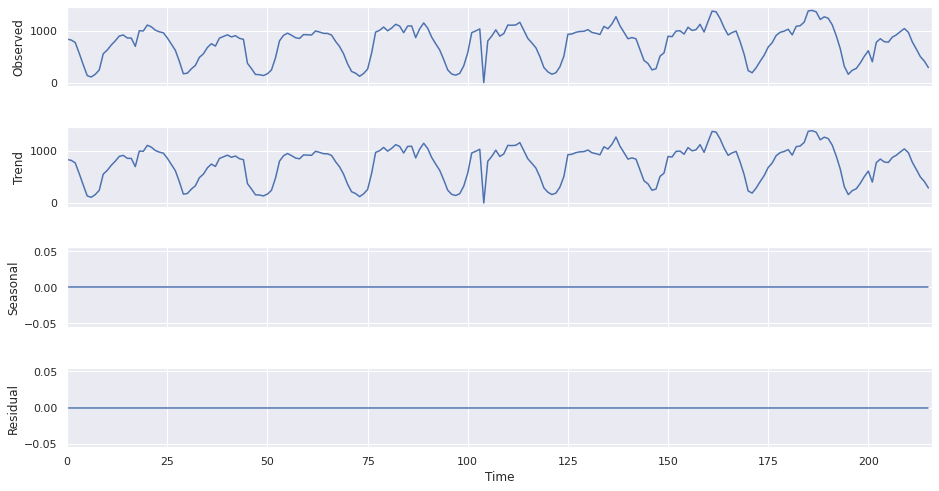

In [ ]:
res = sm.tsa.seasonal_decompose(dt,freq=1)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()